In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,
    roc_auc_score, average_precision_score
)
import lightgbm as lgb
import xgboost as xgb
import re


In [2]:

# ---------- small helpers ----------
_splitter = re.compile(r"[,;\^\s]+")

def count_listish(x):
    """Count items in common 'list-like' encodings without eval."""
    if x is None or (isinstance(x, float) and pd.isna(x)): return 0
    s = str(x).strip()
    if s == "" or s == "[]": return 0
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]
    parts = [p for p in _splitter.split(s) if p]
    return len(parts)

def eval_at_threshold(y_true, y_prob, thr=0.5, label="Model"):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    acc       = accuracy_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    roc_auc   = roc_auc_score(y_true, y_prob)
    pr_auc    = average_precision_score(y_true, y_prob)
    print(f"\n{label} @ threshold={thr:.3f}")
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    return {"thr": thr, "precision": precision, "recall": recall, "accuracy": acc,
            "f1": f1, "roc_auc": roc_auc, "pr_auc": pr_auc}

def best_threshold_by_f1(y_true, y_prob, grid=None):
    if grid is None:
        grid = np.linspace(0.02, 0.50, 49)  # focus on lower thresholds for rare positives
    best = (-1, 0.5)
    for t in grid:
        f1 = f1_score(y_true, (y_prob >= t).astype(int), zero_division=0)
        if f1 > best[0]:
            best = (f1, t)
    return best[1]


In [3]:

# Step 1: Load Data
ads_train = pd.read_csv("../Data/train/train_data_ads.csv")
ads_test = pd.read_csv("../Data/test/test_data_ads.csv")
feeds_train = pd.read_csv("../Data/train/train_data_feeds.csv")
feeds_test = pd.read_csv("../Data/test/test_data_feeds.csv")


In [4]:

# Step 2: Preprocess ads domain data
def preprocess_ads(df):
    categorical_cols_ads = [
        'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group',
        'emui_dev', 'device_name', 'device_size', 'net_type', 'task_id', 'adv_id',
        'creat_type_cd', 'adv_prim_id', 'inter_type_cd', 'slot_id', 'site_id',
        'spread_app_id', 'hispace_app_tags', 'app_second_class'
    ]
    df = df.copy()
    for col in categorical_cols_ads:
        if col in df.columns:
            df[col] = df[col].fillna('unknown').astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    # list columns -> counts (safe parser)
    list_cols_click = ['ad_click_list_001', 'ad_click_list_002', 'ad_click_list_003']
    list_cols_close = ['ad_close_list_001', 'ad_close_list_002', 'ad_close_list_003']
    for col in list_cols_click:
        if col in df.columns:
            df[col] = df[col].fillna('[]').apply(count_listish)
    for col in list_cols_close:
        if col in df.columns:
            df[col] = df[col].fillna('[]').apply(count_listish)

    # time parts
    if 'pt_d' in df.columns:
        s = pd.to_datetime(df['pt_d'].astype(str), format='%Y%m%d%H%M', errors='coerce')
        # fallback if yyyyMMdd only
        if s.isna().all():
            s = pd.to_datetime(df['pt_d'].astype(str), format='%Y%m%d', errors='coerce')
        df['hour'] = s.dt.hour.fillna(-1).astype(int)
        df['dayofweek'] = s.dt.dayofweek.fillna(-1).astype(int)
    return df

# Step 3: Preprocess feeds domain data
def preprocess_feeds(df):
    categorical_cols_feeds = [
        'u_phonePrice', 'u_browserLifeCycle', 'u_browserMode', 'u_feedLifeCycle',
        'u_newsCatInterests', 'u_newsCatDislike', 'u_newsCatInterestsST', 'i_s_sourceId',
        'i_regionEntity', 'i_cat', 'I_dtype', 'e_ch', 'e_m', 'e_pl', 'e_section'
    ]
    list_cols_feeds = ['u_newsCatInterests', 'u_newsCatDislike', 'u_newsCatInterestsST',
                       'u_click_ca2_news', 'i_entities']
    df = df.copy()
    for col in list_cols_feeds:
        if col in df.columns:
            df[col] = df[col].fillna('[]').apply(count_listish)
    for col in categorical_cols_feeds:
        if col in df.columns:
            df[col] = df[col].fillna('unknown').astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    if 'e_et' in df.columns:
        s = pd.to_datetime(df['e_et'].astype(str), format='%Y%m%d%H%M', errors='coerce')
        if s.isna().all():
            s = pd.to_datetime(df['e_et'].astype(str), format='%Y%m%d', errors='coerce')
        df['e_hour'] = s.dt.hour.fillna(-1).astype(int)
        df['e_dayofweek'] = s.dt.dayofweek.fillna(-1).astype(int)
    if 'label' in df.columns:
        df['label'] = df['label'].map({1:1, -1:0})
    return df

# Step 4: Aggregate feeds domain user behavior
def aggregate_feeds_user(df):
    agg_cols = ['u_phonePrice', 'u_browserLifeCycle', 'u_browserMode', 'u_feedLifeCycle',
                'u_refreshTimes', 'u_newsCatInterests', 'u_newsCatDislike', 'u_newsCatInterestsST',
                'u_click_ca2_news']
    agg_dict = {col: 'mean' for col in agg_cols if col in df.columns}
    if 'label' in df.columns:
        agg_dict['label'] = 'mean'
    agg = df.groupby('u_userId').agg(agg_dict).reset_index()
    agg.columns = ['u_userId'] + [f'feeds_{c}' for c in agg.columns if c != 'u_userId']
    return agg


Reading enriched ads train data...
Preparing modeling data...
Class balance (train): pos=95309, neg=6045104, pos_ratio=1.5522%

Raw proportions:
Negatives (0)    0.984478
Positives (1)    0.015522
dtype: float64

Effective (weighted) proportions as seen by model:
Negatives (0)    0.5
Positives (1)    0.5
dtype: float64


/var/folders/bn/z9mnznpj6xqfqqfzfgcbfry00000gn/T/ipykernel_13968/2239513872.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=raw_counts.index, y=raw_counts.values, ax=ax[0], palette='pastel')
/var/folders/bn/z9mnznpj6xqfqqfzfgcbfry00000gn/T/ipykernel_13968/2239513872.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weighted_counts.index, y=weighted_counts.values, ax=ax[1], palette='muted')


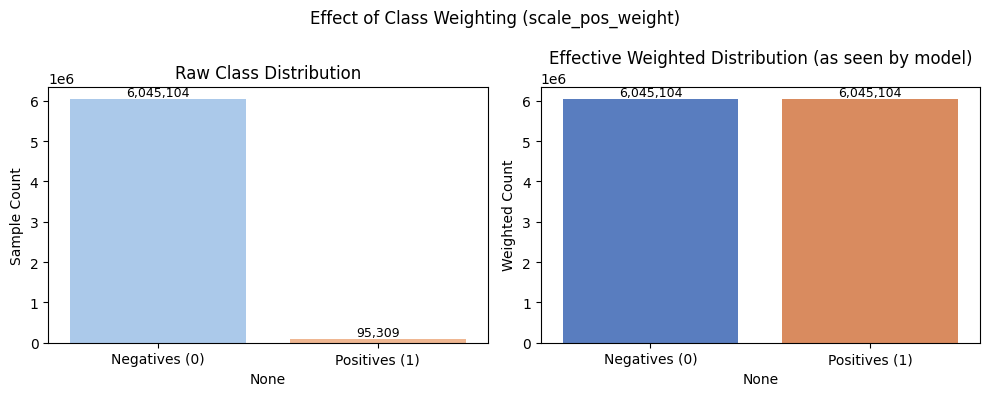

Using scale_pos_weight=63.43


In [6]:
'''
# Apply preprocessors
train_ads_p = preprocess_ads(ads_train)
test_ads_p  = preprocess_ads(ads_test)
train_feeds_p = preprocess_feeds(feeds_train)
test_feeds_p  = preprocess_feeds(feeds_test)

# Combine all feeds for user-level aggregation
all_feeds = pd.concat([train_feeds_p, test_feeds_p], axis=0, ignore_index=True)
feeds_user_agg = aggregate_feeds_user(all_feeds)

# Merge feeds user features into ads by user_id
train_merged = train_ads_p.merge(feeds_user_agg, left_on='user_id', right_on='u_userId', how='left').fillna(0)
test_merged  = test_ads_p.merge(feeds_user_agg,  left_on='user_id', right_on='u_userId',  how='left').fillna(0)
train_merged = train_merged.drop(columns=['u_userId'], errors='ignore')
test_merged  = test_merged.drop(columns=['u_userId'], errors='ignore')
'''
# set train_merged to the enriched ads train data
print("Reading enriched ads train data...")
train_merged = pd.read_csv("ads_train_enriched.csv")
train_merged = train_merged.drop(columns=['u_userId'], errors='ignore')

# Prepare modeling data
print("Preparing modeling data...")
target = 'label'
X = train_merged.drop(columns=[target], errors='ignore')
y = train_merged[target] if target in train_merged.columns else None

# Drop unnecessary columns safely
for col in ['pt_d', 'log_id']:
    if col in X.columns:
        X = X.drop(columns=[col])

# Remove object columns before scaling
for df_ in [X]:
    obj_cols = df_.select_dtypes(include=['object']).columns
    if len(obj_cols):
        df_.drop(columns=obj_cols, inplace=True)

# Train/validation split and scaling
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=[np.number]).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
# common_num = [c for c in num_cols if c in test_merged.columns]
# test_merged[common_num] = scaler.transform(test_merged[common_num])

# ----- Class imbalance ratio -----
pos = int((y_train == 1).sum()); neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(1, pos)
print(f"Class balance (train): pos={pos}, neg={neg}, pos_ratio={pos/(pos+neg):.4%}")

import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualize raw vs weighted class distribution ---
raw_counts = pd.Series({'Negatives (0)': neg, 'Positives (1)': pos})
weighted_counts = pd.Series({
    'Negatives (0)': neg * 1.0,
    'Positives (1)': pos * scale_pos_weight
})

# Normalize to proportions for easy comparison
raw_prop = raw_counts / raw_counts.sum()
weighted_prop = weighted_counts / weighted_counts.sum()

print("\nRaw proportions:")
print(raw_prop)
print("\nEffective (weighted) proportions as seen by model:")
print(weighted_prop)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=raw_counts.index, y=raw_counts.values, ax=ax[0], palette='pastel')
ax[0].set_title("Raw Class Distribution")
ax[0].set_ylabel("Sample Count")
for i, v in enumerate(raw_counts.values):
    ax[0].text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=9)

sns.barplot(x=weighted_counts.index, y=weighted_counts.values, ax=ax[1], palette='muted')
ax[1].set_title("Effective Weighted Distribution (as seen by model)")
ax[1].set_ylabel("Weighted Count")
for i, v in enumerate(weighted_counts.values):
    ax[1].text(i, v, f"{v:,.0f}", ha='center', va='bottom', fontsize=9)

plt.suptitle("Effect of Class Weighting (scale_pos_weight)")
plt.tight_layout()
plt.show()


print(f"Using scale_pos_weight={scale_pos_weight:.2f}")


Performing Principal Component Analysis...
Number of features: 76
Number of components: 76
Components needed for 95% variance: 59
Components needed for 99% variance: 69


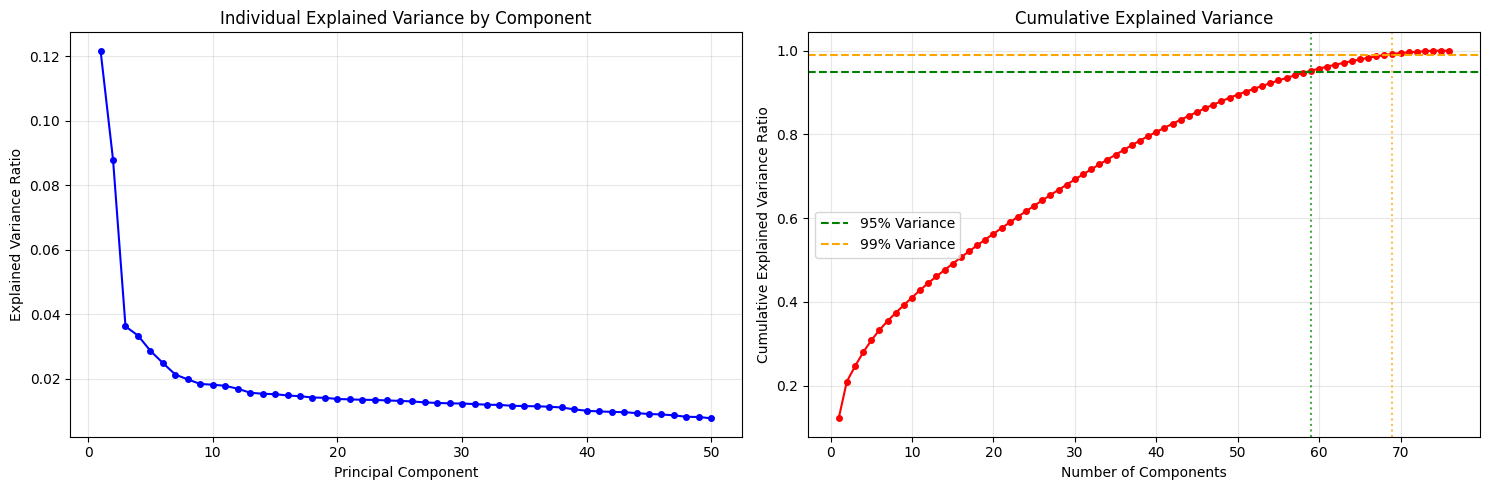


Top 10 features contributing to first 5 principal components:

PC1 (explains 12.166% of variance):
   1. ad_close_list_v002_4      (loading: +0.2980)
   2. ad_close_list_v002_3      (loading: +0.2958)
   3. ad_close_list_v001_4      (loading: +0.2898)
   4. ad_close_list_v001_3      (loading: +0.2866)
   5. ad_close_list_v003_3      (loading: +0.2847)
   6. ad_close_list_v002_5      (loading: +0.2840)
   7. ad_close_list_v001_5      (loading: +0.2821)
   8. ad_close_list_v003_2      (loading: +0.2728)
   9. ad_close_list_v003_4      (loading: +0.2682)
  10. ad_close_list_v002_2      (loading: +0.2678)

PC2 (explains 8.793% of variance):
   1. ad_click_list_v002_4      (loading: +0.3025)
   2. ad_click_list_v002_5      (loading: +0.2916)
   3. ad_click_list_v002_3      (loading: +0.2789)
   4. ad_click_list_v001_5      (loading: +0.2787)
   5. ad_click_list_v001_4      (loading: +0.2747)
   6. ad_click_list_v003_3      (loading: +0.2539)
   7. ad_click_list_v001_3      (loading: +0.243

In [7]:
# Step 5: Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Performing Principal Component Analysis...")

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Transform validation and test data using the same PCA transformation
X_val_pca = pca.transform(X_val)
# X_test_pca = pca.transform(test_merged[common_num])

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print(f"Number of features: {X_train.shape[1]}")
print(f"Number of components: {pca.n_components_}")

# Find number of components for 95% and 99% variance retention
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance_ratio >= 0.99) + 1

print(f"Components needed for 95% variance: {n_components_95}")
print(f"Components needed for 99% variance: {n_components_99}")

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual explained variance
ax1.plot(range(1, min(51, len(explained_variance_ratio) + 1)), 
         explained_variance_ratio[:50], 'bo-', markersize=4)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance by Component')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), 
         cumulative_variance_ratio, 'ro-', markersize=4)
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
ax2.axhline(y=0.99, color='orange', linestyle='--', label='99% Variance')
ax2.axvline(x=n_components_95, color='g', linestyle=':', alpha=0.7)
ax2.axvline(x=n_components_99, color='orange', linestyle=':', alpha=0.7)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top 10 most important features (highest absolute loadings)
feature_names = X_train.columns
n_top_features = 10

# Get the first few principal components and their loadings
n_components_to_show = min(5, pca.n_components_)
print(f"\nTop {n_top_features} features contributing to first {n_components_to_show} principal components:")

for i in range(n_components_to_show):
    # Get absolute loadings for component i
    loadings = np.abs(pca.components_[i])
    # Get indices of top features
    top_indices = np.argsort(loadings)[-n_top_features:][::-1]
    
    print(f"\nPC{i+1} (explains {explained_variance_ratio[i]:.3%} of variance):")
    for j, idx in enumerate(top_indices):
        feature_name = feature_names[idx]
        loading_value = pca.components_[i][idx]
        print(f"  {j+1:2d}. {feature_name:<25} (loading: {loading_value:+.4f})")

# For now, let's use 95% variance retention for the PCA features
print(f"\nUsing {n_components_95} components to retain 95% of variance")
X_train_pca_reduced = X_train_pca[:, :n_components_95]
X_val_pca_reduced = X_val_pca[:, :n_components_95]
# X_test_pca_reduced = X_test_pca[:, :n_components_95]

print(f"Original feature shape: {X_train.shape}")
print(f"PCA reduced shape: {X_train_pca_reduced.shape}")
print(f"Dimension reduction: {X_train.shape[1]} -> {X_train_pca_reduced.shape[1]} features")


In [10]:

# Step 9: Logistic regression (balanced)
print("\nLogistic Regression (balanced) Results:")
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr.fit(X_train, y_train)
p_val_lr = lr.predict_proba(X_val)[:, 1]
thr_lr = best_threshold_by_f1(y_val, p_val_lr)
eval_at_threshold(y_val, p_val_lr, thr=thr_lr, label="Logistic Regression (balanced)")



Logistic Regression (balanced) Results:

Logistic Regression (balanced) @ threshold=0.500
Confusion Matrix:
 [[1098708  412569]
 [   8897   14930]]
Precision: 0.0349, Recall: 0.6266, Accuracy: 0.7254, F1: 0.0662, ROC-AUC: 0.7525, PR-AUC: 0.0831


{'thr': np.float64(0.5),
 'precision': 0.03492405830189076,
 'recall': 0.6266000755445503,
 'accuracy': 0.7254479175352289,
 'f1': 0.0661606023140701,
 'roc_auc': 0.7525144107087798,
 'pr_auc': 0.083124605366628}

In [ ]:

# Step 10: LightGBM (with scale_pos_weight)
print("\nLightGBM Results:")
train_data = lgb.Dataset(X_train, label=y_train)
val_data   = lgb.Dataset(X_val,   label=y_val, reference=train_data)
params = {
    'objective': 'binary',
    'metric': ['binary_logloss','auc'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'learning_rate': 0.05,
    'num_leaves': 63,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'scale_pos_weight': float(scale_pos_weight),
}
lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=4000,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)
p_val_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
thr_lgb = best_threshold_by_f1(y_val, p_val_lgb)
eval_at_threshold(y_val, p_val_lgb, thr=thr_lgb, label="LightGBM (spw)")


: 

In [ ]:

# Step 11: XGBoost (with scale_pos_weight)
print("\nXGBoost Results:")
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss','auc'],
    'seed': 42,
    'eta': 0.05,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'scale_pos_weight': float(scale_pos_weight),
}
xgb_model = xgb.train(params_xgb, dtrain, num_boost_round=4000,
                      evals=[(dval, 'val')], early_stopping_rounds=100,
                      verbose_eval=False)


best_iter = getattr(xgb_model, "best_iteration", None)
if best_iter is not None:
    p_val_xgb = xgb_model.predict(dval, iteration_range=(0, best_iter + 1))
else:
    p_val_xgb = xgb_model.predict(dval)



thr_xgb = best_threshold_by_f1(y_val, p_val_xgb)
eval_at_threshold(y_val, p_val_xgb, thr=thr_xgb, label="XGBoost (spw)")


Building Neural Network with PCA Features...
Input shape: (6140413, 59)
Class distribution - Positives: 95309, Negatives: 6045104
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,417 (236.00 KB)

 Trainable params: 59,521 (232.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training with class weights: {0: 1.0, 1: 63.42637106674081}
Starting training...
Epoch 1/50
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step - accuracy: 0.7280 - loss: 1.1345 - precision: 0.0361 - recall: 0.6421 - val_accuracy: 0.7481 - val_loss: 0.5422 - val_precision: 0.0394 - val_recall: 0.6519 - learning_rate: 0.0010
Epoch 2/50
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 91s 15ms/step - accuracy: 0.7584 - loss: 1.0923 - precision: 0.0405 - recall: 0.6416 - val_accuracy: 0.7588 - val_loss: 0.5358 - val_precision: 0.0406 - val_recall: 0.6422 - learning_rate: 0.0010
Epoch 3/50
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 90s 15ms/step - accuracy: 0.7617 - loss: 1.0851 - precision: 0.0411 - recall: 0.6429 - val_accuracy: 0.7708 - val_loss: 0.5401 - val_precision: 0.0420 - val_recall: 0.6320 - learning_rate: 0.0010
Epoch 4/50
5997/5997 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step - accuracy: 0.7666 - loss: 1.0807 - precision: 0.0419 - recall: 0.6413 - val_accuracy: 0.7776 - val_loss: 0.5275 - val_precision: 0.0429 - val_recal

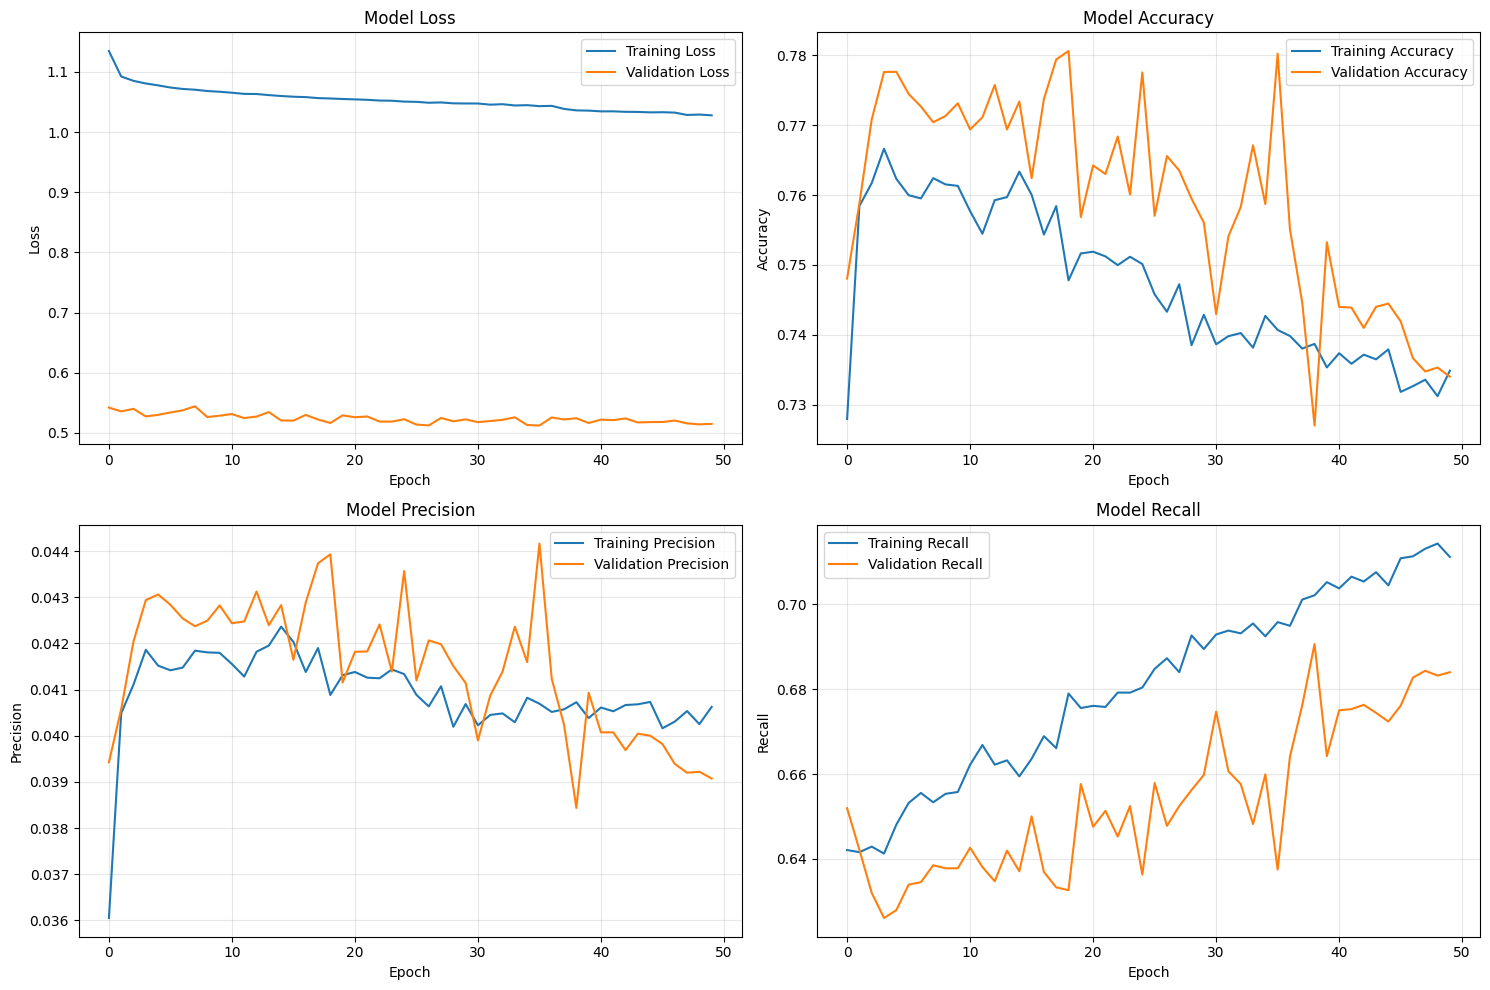


Neural Network Feature Importance Analysis:
Top 15 most important PCA components (based on first layer weights):
 1. PC49: 0.5839
 2. PC52: 0.5751
 3. PC51: 0.5036
 4. PC7: 0.4807
 5. PC56: 0.4658
 6. PC47: 0.4584
 7. PC48: 0.4523
 8. PC44: 0.4408
 9. PC3: 0.4147
10. PC39: 0.4080
11. PC13: 0.4023
12. PC53: 0.3981
13. PC8: 0.3842
14. PC50: 0.3798
15. PC37: 0.3787

Neural Network training completed!
Final validation metrics at threshold 0.5000:
- F1 Score: 0.0728
- Recall: 0.6906
- PR-AUC: 0.1153


In [8]:
# Step 12: Neural Network with PCA Features
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

print("Building Neural Network with PCA Features...")
print(f"Input shape: {X_train_pca_reduced.shape}")
print(f"Class distribution - Positives: {y_train.sum()}, Negatives: {len(y_train) - y_train.sum()}")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Build the neural network architecture
def create_nn_model(input_dim, class_weight_ratio):
    model = keras.Sequential([
        # Input layer
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile with class weighting
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Create the model
model = create_nn_model(X_train_pca_reduced.shape[1], scale_pos_weight)
print(f"Model architecture:")
model.summary()

# Define class weights for imbalanced data
class_weight = {0: 1.0, 1: scale_pos_weight}

# Callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_recall',  # Focus on recall for imbalanced data
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

print(f"\nTraining with class weights: {class_weight}")
print("Starting training...")

# Train the model
history = model.fit(
    X_train_pca_reduced, y_train,
    validation_data=(X_val_pca_reduced, y_val),
    epochs=50,
    batch_size=1024,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# Make predictions
y_pred_proba = model.predict(X_val_pca_reduced, verbose=0).flatten()
# y_pred_proba_test = model.predict(X_test_pca_reduced, verbose=0).flatten()

# Find best threshold based on F1 score
best_threshold = best_threshold_by_f1(y_val, y_pred_proba)
print(f"\nBest threshold for F1 score: {best_threshold:.4f}")

# Evaluate the model
print("\nNeural Network Results:")
eval_at_threshold(y_val, y_pred_proba, thr=best_threshold, label="Neural Network (PCA)")

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0,0].plot(history.history['loss'], label='Training Loss')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Accuracy
axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision
axes[1,0].plot(history.history['precision'], label='Training Precision')
axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
axes[1,0].set_title('Model Precision')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Precision')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Recall
axes[1,1].plot(history.history['recall'], label='Training Recall')
axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
axes[1,1].set_title('Model Recall')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Recall')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis (using the first layer weights)
print("\nNeural Network Feature Importance Analysis:")
first_layer_weights = model.layers[0].get_weights()[0]  # Get weights from first layer
feature_importance = np.abs(first_layer_weights).mean(axis=1)  # Average absolute weights across neurons

# Get top 15 most important features
top_features_idx = np.argsort(feature_importance)[-15:][::-1]
print("Top 15 most important PCA components (based on first layer weights):")
for i, idx in enumerate(top_features_idx):
    print(f"{i+1:2d}. PC{idx+1}: {feature_importance[idx]:.4f}")

print(f"\nNeural Network training completed!")
print(f"Final validation metrics at threshold {best_threshold:.4f}:")
print(f"- F1 Score: {f1_score(y_val, (y_pred_proba >= best_threshold).astype(int), zero_division=0):.4f}")
print(f"- Recall: {recall_score(y_val, (y_pred_proba >= best_threshold).astype(int), zero_division=0):.4f}")
print(f"- PR-AUC: {average_precision_score(y_val, y_pred_proba):.4f}")
